In [53]:
# Goal: use the parameters derived from the BB fits to estimate the color velocity
# similar to what's used in the Piro+2014 paper
import numpy as np
import numba
import dynesty
import astropy.table as table
from dynesty import plotting as dyplot
import astropy.units as u

In [75]:
bbfit = table.Table.read('../products/specs/bbfit.fits')
bbfit

<Table length=26>
       phase                logz        ... instrument int_flux_mismatch 
      float64             float64       ...   bytes1        float64      
------------------- ------------------- ... ---------- ------------------
-18.210428240709007 -24.090732262325055 ...                           nan
-17.147404259070754   -13.6783579407864 ...                           nan
-16.916725694201887 -13.028752154294036 ...                           nan
-15.194287037011236  -17.23793240242839 ...                           nan
-13.007756041828543 -21.018944251803948 ...            1.0351870947533848
-12.200670138932765  -15.12271500207135 ...                           nan
 -9.388772106263787 -11.145418837116026 ...                           nan
 -8.166097222361714   -9.86175326817085 ...                           nan
 0.9335266202688217   -9.88191914994181 ...                           nan
  7.950689814984798 -10.960441863729748 ...                           nan
                ...                 ... ...        ...                ...
 42.659954907372594 -14.414095237107842 ...                           nan
 47.777202546130866 -14.089143922071445 ...                           nan
  55.71297106472775 -16.239697683238823 ...                           nan
  62.77637847233564  -18.45040072965433 ...                           nan
  74.55890408577397  -24.91490462957499 ...                           nan
  75.88669212954119  -32.46847591646597 ...                           nan
  99.72989005502313  -68.27780657094958 ...                           nan
 102.79355089971796 -51.874239815469515 ...                           nan
 116.76801736094058 -31.919971773725305 ...                           nan
 136.85717824054882  -66.57685398817544 ...                           nan

In [76]:
np.log(bbfit['radius_q95'].max())

35.846654577050785

In [77]:
np.log(bbfit['radius_q5'].min())

33.231330599342826

In [78]:
@numba.njit
def prior(u):
    p = np.empty(len(u))
    # explosion epoch offset in days before peak
    p[0] = 20*u[0] + 19
    # log of color velocity
    p[1] = 22*u[1]
    p[2:] = 6*u[2:] + 30
    return p

In [79]:
@numba.njit
def likelihood(p, obs_phase, obs_color_radii, obs_color_radii_err):
    t_expl = p[0]
    ln_v_color = p[1]
    
    radii = p[2:]
    t_phase = obs_phase + t_expl
    
    radius_model = ln_v_color + np.log(t_phase*3600*24)
    
    sigma2_obs = obs_color_radii_err ** 2
    log_l1 = np.sum((radii-obs_color_radii)**2 / sigma2_obs)
    log_l2 = np.sum((radii-radius_model)**2)
    
    return -0.5 * (log_l1 + log_l2)
    

In [80]:
#idx = bbfit['phase'] < -12
idx = bbfit['phase'] < 0
obs_phase = np.array(bbfit['phase'][idx], dtype=np.double)
obs_color_radii = np.array(np.log(bbfit['radius_mean'][idx]), dtype=np.double)
err_minus = (bbfit['radius_q95']-bbfit['radius_mean'])/2
err_plus = (bbfit['radius_mean']-bbfit['radius_q5'])/2
log_err_minus = np.log(bbfit['radius_mean'])  - np.log(bbfit['radius_mean'] - err_minus)
log_err_plus = np.log(bbfit['radius_mean'] + err_plus) - np.log(bbfit['radius_mean'])
log_err = np.empty(shape=len(log_err_minus))
for i in range(len(log_err)):
    log_err[i] = max(log_err_minus[i], log_err_plus[i])
#obs_color_radii_err = np.array((np.log(bbfit['radius_q95'])-np.log(bbfit['radius_q5']))[idx], dtype=np.double)
obs_color_radii_err = log_err[idx]

args = (obs_phase, obs_color_radii, obs_color_radii_err)
sampler = dynesty.NestedSampler(likelihood, prior, 2+len(obs_phase), logl_args=args, nlive=4000)

In [81]:
sampler.run_nested()

83442it [03:37, 382.81it/s, +4000 | bound: 116 | nc: 1 | ncall: 1872317 | eff(%):  4.670 | loglstar:   -inf < -1.311 <    inf | logz: -24.790 +/-  0.252 | dlogz:  0.003 >  4.009]


AttributeError: 'Text' object has no property 'quantiles'

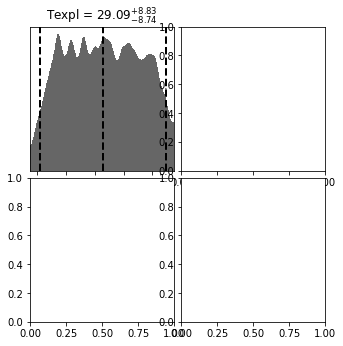

In [88]:
results = sampler.results
dyplot.cornerplot(results, dims=[0,1], labels=['Texpl', 'ln v_c'], show_titles=True)

(<Figure size 1908x1908 with 144 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{2}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$x_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
     

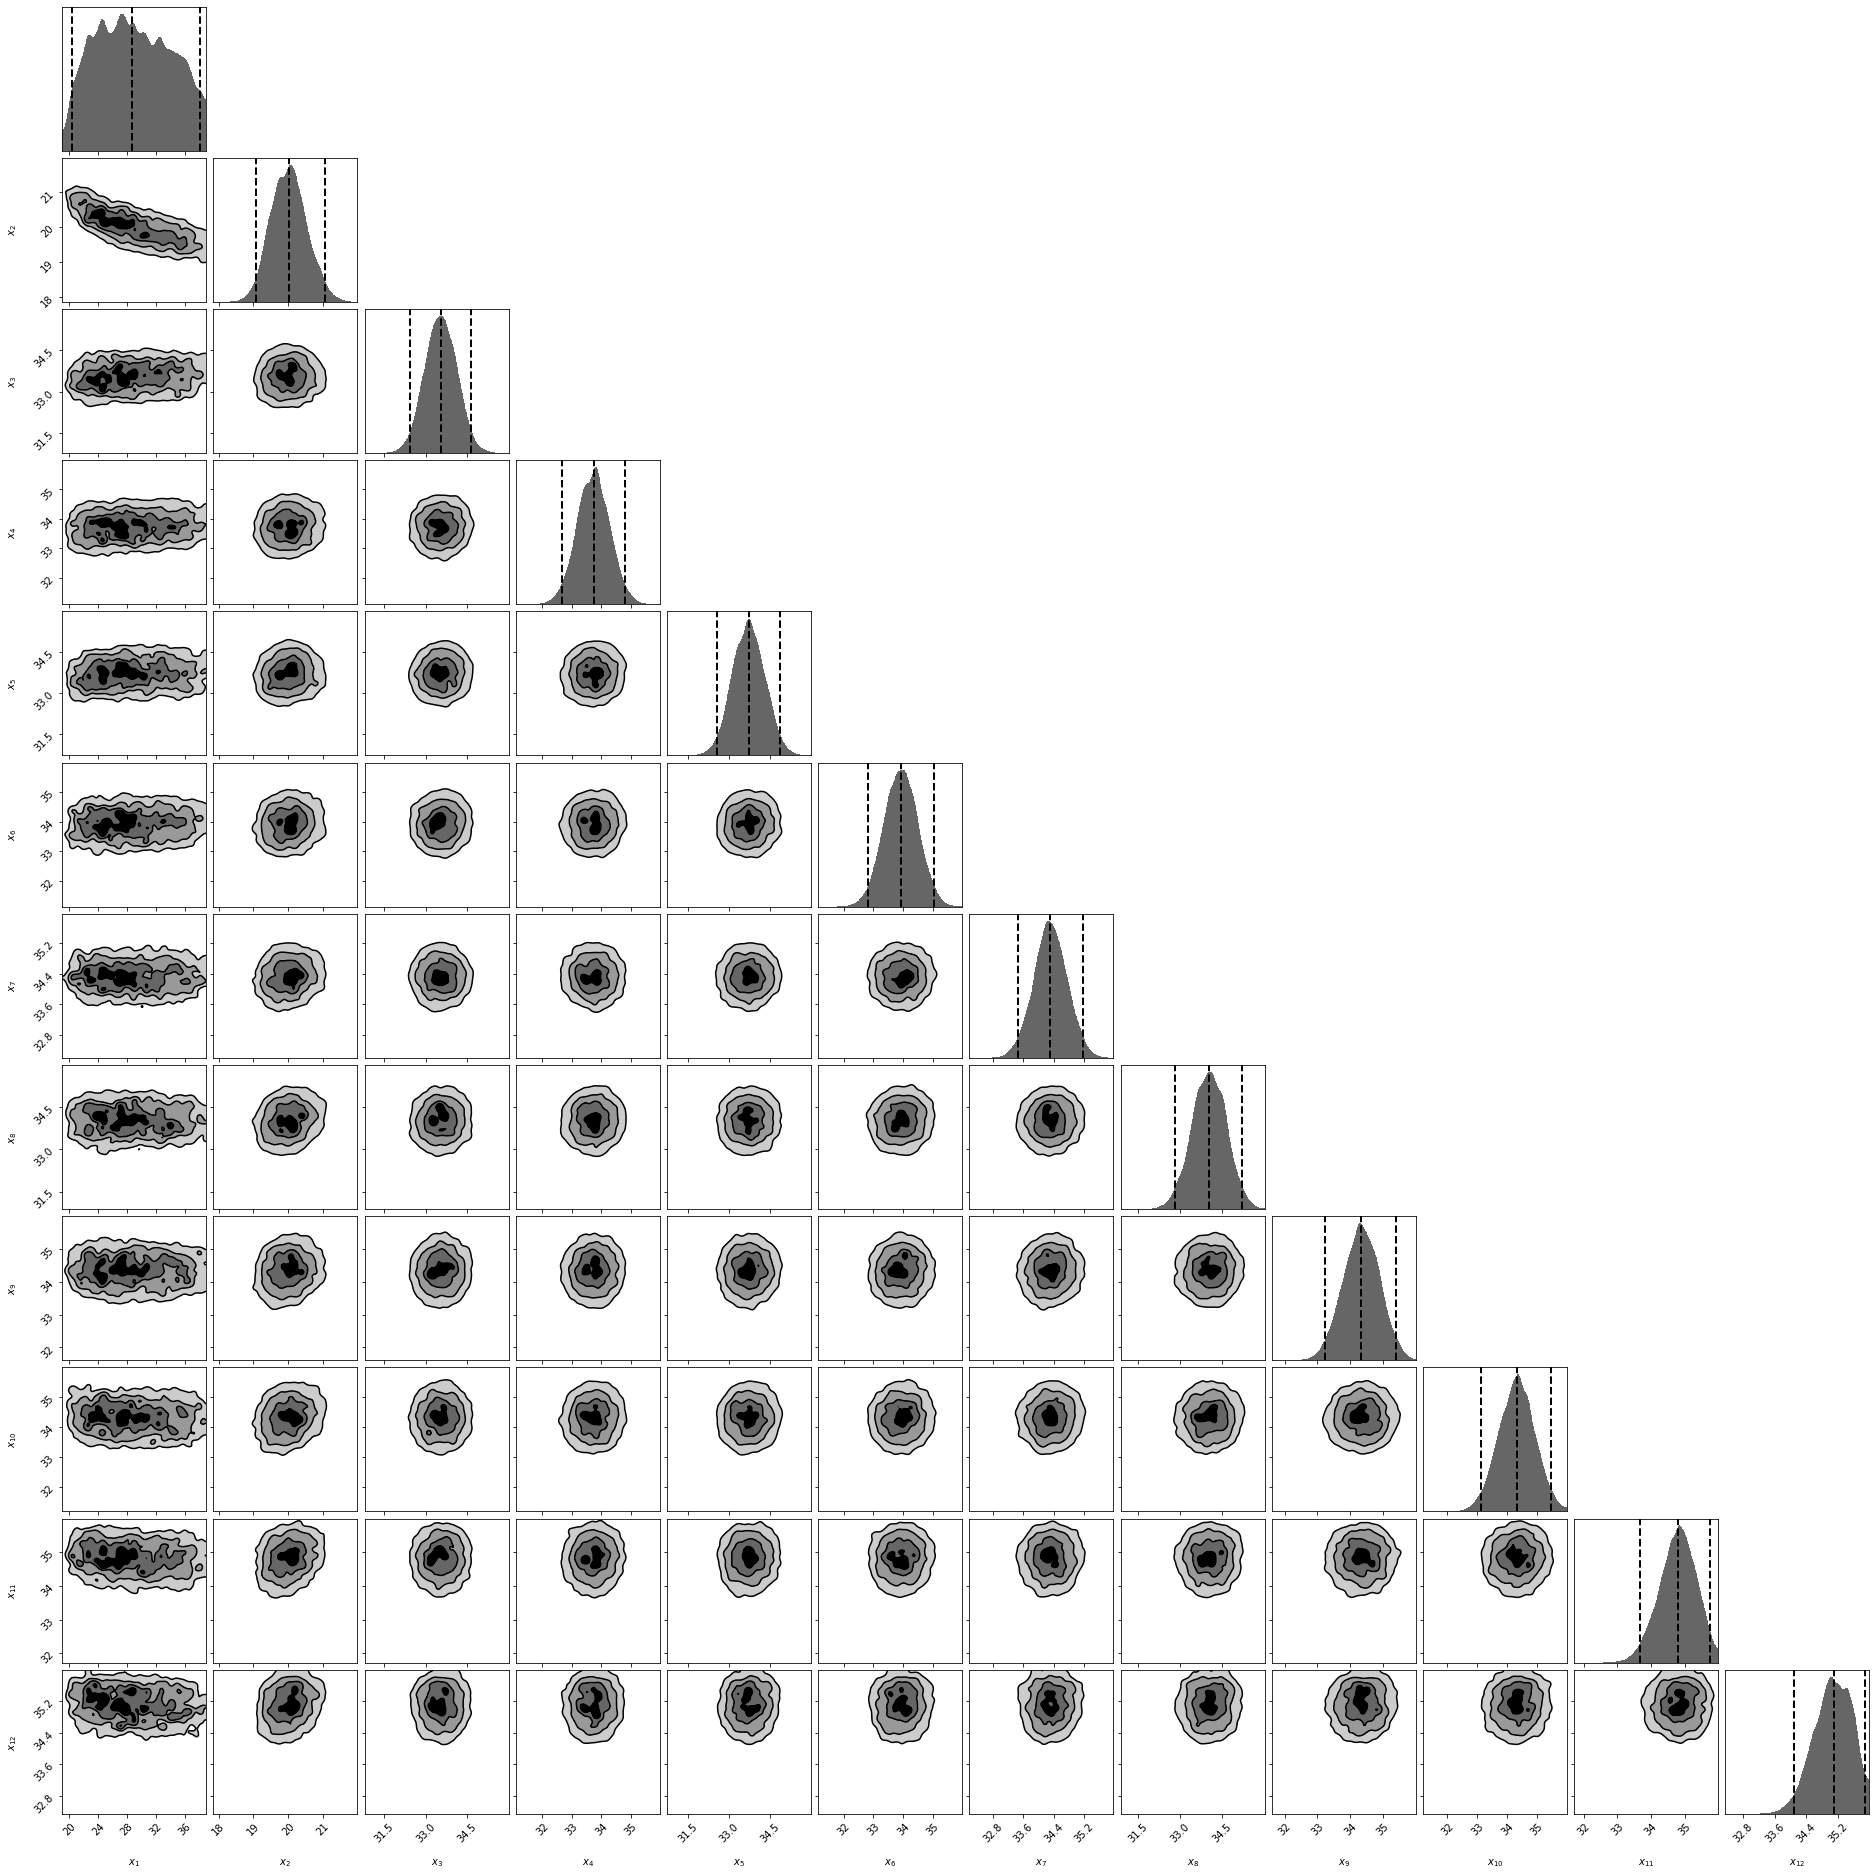

In [61]:
results = sampler.results
dyplot.cornerplot(results)

In [44]:
obs_color_radii

array([33.518528  , 33.74563174, 33.68545271, 33.92542382, 34.37246081,
       33.9621024 , 34.35025636, 34.31569639, 34.8614364 , 35.26047929])

In [45]:
radius_model

NameError: name 'radius_model' is not defined

In [47]:
obs_phase + 19 + 20

array([20.78957176, 21.85259574, 22.08327431, 23.80571296, 25.99224396,
       26.79932986, 29.61122789, 30.83390278, 39.93352662, 46.95068981])

In [51]:
np.log(np.exp(13)*24*3600*20)

27.36247522834614

In [54]:
np.exp(13)*u.cm.to(u.km)

4.424133920089205

In [55]:
np.log(3e4*u.km.to(u.cm))

21.82187812561452

In [62]:
obs_color_radii_err

array([0.67005702, 0.64317077, 0.70453579, 0.65655076, 0.47515743,
       0.73019024, 0.66098948, 0.75033901, 0.70822683, 0.64422499])

In [63]:
np.log(2)

0.6931471805599453

In [86]:
dyplot.cornerplot?

In [91]:
import astropy.constants as const
C1 = 2.0 * const.h.cgs * const.c.cgs**2
C2 = const.h.cgs * const.c.cgs / const.k_B.cgs
C1, C2

(<Quantity 1.19104297e-05 cm2 erg / s>, <Quantity 1.43877688 cm K>)

In [92]:
def planck_function(wavelength, temperature):
    """Planck function at given `wavelength` and `temperature` in cgs.

    The specific intensity of radiation from a blackbody source is given by:

    :math:`B_{\\lambda}(\\lambda, T) = \\displaystyle\\frac{C_1}{\\lambda^5} \\frac{1}{e^{\\frac{C_2}{\\lambda T}} - 1}`

    where :math:`C_1 = 2hc^2` and :math:`C_2 = hc/k_B` are the first and second radiation constants.

    Args:
        wavelength (float): Wavelength in Angstrom
        tempereature (float): Temperature in Kelvin

    Returns:
        Astropy Quantity: The specific intensity of the
        Planck function in :math:`erg \\; s^{-1} cm^{-2} sterad^{-1} Angstrom^{-1}`
    """
    wavelength = u.Quantity(wavelength, unit=u.Angstrom)
    temperature = u.Quantity(temperature, unit=u.K)

    C1 = 2.0 * const.h.cgs * const.c.cgs**2
    C2 = const.h.cgs * const.c.cgs / const.k_B.cgs

    B_lambda = (C1 / wavelength**5) / \
               (np.expm1(C2 / (wavelength * temperature))) / u.sr
    B_lambda = B_lambda.to(u.erg / (u.s * u.cm**2 * u.AA * u.sr))

    return B_lambda

In [94]:
planck_function(np.linspace(3500, 25000), 1000)

<Quantity [3.18162062e-09, 1.71783463e-07, 3.94224257e-06, 4.88323872e-05,
           3.82487946e-04, 2.11236280e-03, 8.88662812e-03, 3.01299226e-02,
           8.58614308e-02, 2.12328296e-01, 4.67037538e-01, 9.31636978e-01,
           1.71153796e+00, 2.93196117e+00, 4.73089534e+00, 7.25003577e+00,
           1.06250130e+01, 1.49761569e+01, 2.04007691e+01, 2.69675086e+01,
           3.47131310e+01, 4.36415171e+01, 5.37247101e+01, 6.49055578e+01,
           7.71015071e+01, 9.02091100e+01, 1.04108851e+02, 1.18669969e+02,
           1.33755037e+02, 1.49224113e+02, 1.64938374e+02, 1.80763159e+02,
           1.96570431e+02, 2.12240667e+02, 2.27664221e+02, 2.42742225e+02,
           2.57387073e+02, 2.71522572e+02, 2.85083807e+02, 2.98016788e+02,
           3.10277928e+02, 3.21833395e+02, 3.32658388e+02, 3.42736357e+02,
           3.52058205e+02, 3.60621489e+02, 3.68429635e+02, 3.75491193e+02,
           3.81819116e+02, 3.87430099e+02] erg / (Angstrom cm2 s sr)>

In [97]:
def load_filter_curve(instrument='ZTF', band='r'):
    if instrument == 'ZTF':
        dat = table.Table.read('../const/filters/Palomar_ZTF.%s.dat' % band, format='ascii')
        return dat['col1'], dat['col2']

In [99]:
ztf_g = load_filter_curve(band='g')
filter_wave, filter_response = ztf_g
filter_response[0] = 0
filter_response[-1] = 0
filter_response[filter_response < 0] = 0
